#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Week 1 - Notebook 2

# Overview

Welcome to Week 1: Part 2 of this course!  In our first notebook we handled the data preprocessing steps which included:
- Chunking/splitting
- Vectorization of text
- Combining with metadata
- Saving to disk

We'll move on now to working with **Weaviate** to perform the following operations:
- Class Configuration
- Data Indexing
- Keyword search
- Vector search
- OPTIONAL: Searching with Filters

![weaviate]( 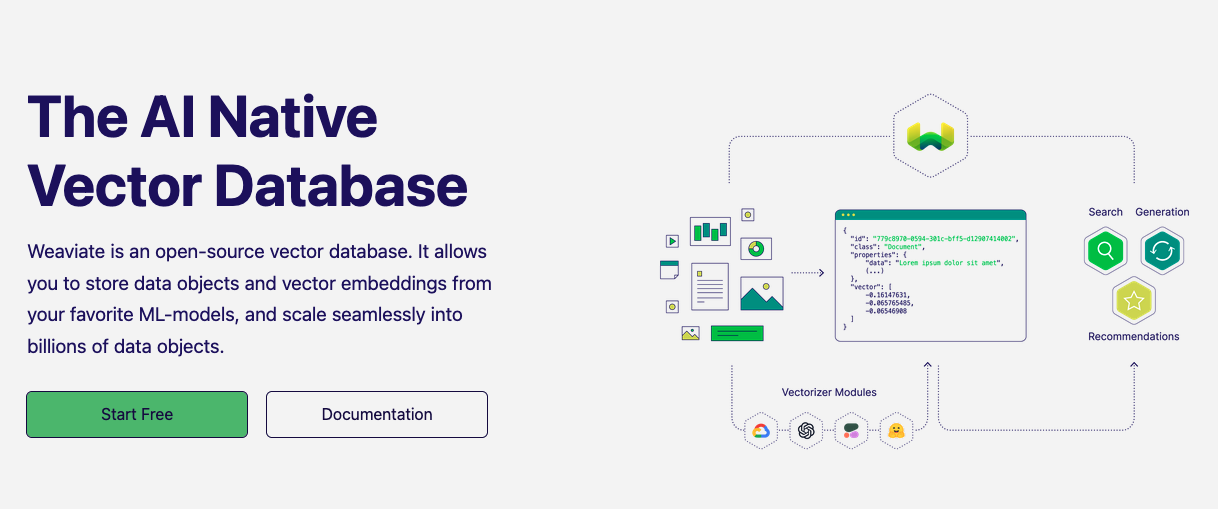)

# Approach
As a reminder, we will divide the approach to building this system into four parts over two weeks-

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* Part 2 **(THIS NOTEBOOK)**:
  * Index data on Weaviate database
  * Search over data
* Part 2.5:
  * Benchmark retrieval results

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with GPT-Turbo
* Part 4:
  * Display results in Streamlit

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

In [60]:
!pip install weaviate-client==3.25.3 --quiet
!pip install rich --quiet   #convenient library for pretty printing

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]


In [61]:
#external files
from preprocessing import FileIO
from weaviate_interface import WeaviateClient, WeaviateIndexer

#standards
import os
import time
import json
from typing import List
from tqdm.notebook import tqdm

from rich import print  # nice library that provides improved printing output (overrides default print function)

#load from local .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

## Setup

<div class="alert alert-danger"><h3>This Notebook assumes that you have 
    already created an account with Weaviate and have created a Weaviate instance on Weaviate Cloud Services (WCS)</h3></div>

1. If you have not created a Weviate account, go here: [Weaviate Account setup video](https://www.loom.com/share/0ad6f80bcb0e4a3aa7c7ac032596ed89?sid=0cdf3b6e-f251-4eda-bf28-b1d2d4af70e7)
2. If you have not created a Weaviate cluster, go here: [Weaviate Cluster setup video](https://www.loom.com/share/cccd9b52fa374c3c97dc84b6854ab14b?sid=cda33892-bb9e-42c3-8126-06ac8d7cc6fd)

### Instantiate Weaviate Client

The `WeaviateClient` Class is a convenient wrapper around the Weaviate python API.  We'll use it to create a Weaviate client to connect with our Weaviate Cloud instance.  
Instantiating the Class requires 3 main pieces of information that will change from user to user:
- a model name or path for use with vector searches - this is the model that will create an embedding from the query string
- the Weaviate instance endpoint 
- your personal Weaviate api key

In a production setting you'd have to account for security layers, but for this course we'll be working with a dev instance. 

In [62]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']


#instantiate client
client = WeaviateClient(api_key, url, model_name_or_path="sentence-transformers/all-mpnet-base-v2")

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

### Load Saved Data from Disk (from previous notebook)

In [63]:
# data_path = "/Users/20010704/Projects/Personal/complete-projects/vectorsearch-applications/data/impact-theory-minilmL6-256.parquet"
data_path = "/Users/20010704/Projects/Personal/complete-projects/vectorsearch-applications/data/impact-theory-mlpnetbasev2-384.parquet"

class_name = "ImpactTheorymlpnetbasev2_384_v3"
chunk_size = 384

data = FileIO().load_parquet(data_path)

Shape of data: (17336, 12)
Memory Usage: 1.59+ MB


## Intuition
***

Now that we've instantiated our Weaviate client as a connection with our Weaviate Host in the cloud, as well as loaded our data in memory, we're prepared to Index our data.  We'll follow the below steps:  

1. **Define a schema of Class properties**: This step allows us to be precise on data types, filterablitiy, and indexability.
2. **Define a Class configuration**: This is our chance to configure how we want our Class (index) to run.  As part of this configuration we'll insert our schema of properties.
3. **Index Data on Weaviate**: Index our data using batch uploads. 

Including a **Terms Comparison Table** below (hope this helps avoid more confustion that it creates 😊).  
Terms are ranked in increasing order of information granularity i.e. a `Class` is a collection of `Data Objects` which are in turn a collection of `Properties`.



<table style='float:left'>
    <tr>
        <th><h3>Weaviate Term</h3></th>
        <th><h3>OpenSearch Equivalent</h3></th>
        <th><h3>Relational DB Equivalent</h3></th>
    </tr>
    <tr>
        <td>Class</td>
        <td>Index</td>
        <td>Table</td>
    </tr>
    <tr>
        <td>Data Object</td>
        <td>Document</td>
        <td>Row</td>
    </tr>
    <tr>
        <td>Property</td>
        <td>Field</td>
        <td>Column</td>
    </tr>
</table>

***

### Step 1 --> Define a Schema of Class Properties

Weaviate supports an auto-schema option wherein properties are defined during data ingestion, however, for greater precision we are going to manually define each of our properties.  We'll define the following parameters for each property:
   - `name`: the name of the property, for simplicity we'll ensure that each name corresponds with each key/field of each entry in our data
   - `dataType`: the type of data i.e. `text`, `number`, `date`, etc.
   - `indexFilterable`: should we be able to filter on this property? 
   - `indexSearchable`: should we be able to search over this property?  Do not set this property to "true" if you do not intend to search over this property.
   - Property example:
        ```
           {
             {
              'name': 'video_id',
              'dataType': ['text'],
              'indexFilterable': True,
              'indexSearchable': True
             },
             {
              'name': 'length',
              'dataType': ['number'],
              'indexFilterable': True,
              'indexSearchable': False
             },
            }
        ```

<div class="alert alert-success"><h5>In the interest of time, I've created schema template that can be imported as an example to get us started. Import the pre-defined schema of class properties from the class_templates.py file and print to screen.  </h5></div>

In [64]:
from class_templates import impact_theory_class_properties

##############
# START CODE #
##############

print(impact_theory_class_properties)

[
    {'name': 'title', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
    {'name': 'video_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'length', 'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'thumbnail_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
    {'name': 'views', 'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'episode_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
    {'name': 'doc_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'guest', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
    {'name': 'summary', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True},
    {'name': 'content', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True}
]

Compare the imported schema with the metadata fields from one of the entries in the `data` variable.  Every use case will be different so we may not want to index or create a filter for every single piece of metadata.  Being selective and deciding in advance how you want to configure your index is an important step.  On the other hand, depending on the size of the data you're working with, sometimes you're better off including metadata that you aren't sure if you're going to use, because the cost of adding it later or having to reindex all of your data can be prohibitive.  

One other thing to note which is particular to Weaviate is that you don't see a `content_embedding` property where a user can set a property for a list of floats for a vector representation.  The vector property is added to the schema during data indexing and is handled as a separate action, this is likely the case because Weaviate is a native vector database first with the additional benefit of being able to filter and search using keywords.  This paradigm is different from other databases such as Elastic/Opensearch wherein the vector data field is predefined as part of the schema just like all the other property types. 
Here's an example from Elasticsearch of what I'm referring to:  
```
PUT index
{
 "mappings": {
   "properties": {
     "image-vector": {
       "type": "dense_vector",
       "dims": 128,
       "index": true,
       "similarity": "l2_norm"
     }
   }
 }
}
```

***

# Assignment 2.1 - Answer the following questions about the properties schema

1. Which four properties will we be able to search over?  Why do you think those fields were chosen?
2. How many different dataTypes will we be working with?
3. Which fields from the original data are not being included as a property in this schema? Why are they not being included?
4. Why aren't we setting every property to True for `indexSearchable`?

<details>
  <summary>Click to reveal Answers</summary> 
    
#### Answers
1. Searchable properties = [`title`, `guest`, `summary`, `content`].  These fields are chosen because they are the fields that an end user is most likely going to want to search over and have the highest density of information gain.  For example, an end user may want to search for what a particular guest said on a specific episode.  If they had the `video_id`, they won't "search" for the `video_id`, rather they'll filter by `video_id` and then lookup the topic by searching the `content` property.
2. For this schema we are working with only 2 `dataTypes`: `text` and `int`.  Float values in Weaviate fall under the `number` `dataType`.
3. The two values not being included are `playlist_id` and `content_embedding`.  `playlist_id` is not needed for any type of searching or filtering because all episodes have the same playlist id.  If we were to incorporate other playlists onto this class we may want to include that item as a filterable object.  `content_embedding` will be added to the class at a later step during the indexing process.
4. Give your database a break and don't index everything if you aren't going to actually search over it.  For example `length` (length of video in total seconds) and `views` (number of video views) are great properties for filtering, but end users aren't going to search over these properties, so don't index them.  `episode_url` is neither filterable nor indexable, but is being included so that it appears as a displayed property so that end users can click to the episode in the UI. 
</details>
***

### Step 2 --> Define a Class Configuration

A Class configuration is a blueprint of how our data is to be organized and stored on the Weaviate cluster.  But before defining our Class configuration, it would help if we gave our class a name.  Similar to the way we named our datasets, we'll want to enforce a standard class/index naming convention from the very outset.  This step is actually very important because as we add classes to our Weaviate cluster it's nice to know at a glance which one we're working with.  Also, we may decide to use a different embedding model, so knowing which model was used for any given class is important. 

- name of Podcast
- model name
- chunk size

Example:

`Impact_theory_minilm_256`

*** A quick, but important note here about class naming conventions. Weaviate client APIs are transitioning from the term "class" to "collection." Older Weaviate documentation refers to "classes." Newer documentation uses "collections." Expect to see both terms in the docs during the transition period. For our `Vector Search Applications` course I will refer to them synonymously as either a class or an index. Given that old habits die hard, from my experience with Elasticsearch and OpenSearch, I will likely refer to them as indexes.

**Weaviate Class Naming Rules**:

- Class names are always written with an initial capital letter.
- After the first letter, you can use any alphanumeric character, both lower and upper-case, and underscores.
- No hyphens ☹️



In [65]:
#create your own class name or use the example from above


The code below constructs a class configuration.  The primary variables that will change from one class to another are the `class` (name of the class) and the `properties` fields.  The other config fields to consider are ones which tune the HNSW graph which is built during data indexing time.  Something else to point out is that the `vectorizer` field in the below config is marked as `"none"`.  Weaviate supports several types of built in vectorization models, however, we are bringing our own embeddings (BYOE) so it's important to mark this field as `none` so that the database knows not to unnecessarily vectorize any of our incoming data. Carefully read through the tuning parameters before moving on. 

- `class`: The name of the class in string format
- `description`: Human-readable class description for your reference
- `vectorIndexType`: ANN algorithm to use (not that you have choice with weaviate 😉). Other vector DBs, like [Milvus](https://milvus.io/), allow various options here.
- `ef`: Balance search speed and recall. The ef parameter controls the size of the approximate nearest neighbors (ANN) list at query time.. Search is more accurate when ef is
        higher, but it is also slower.  Default value is `-1` which means Weaviate will dynamically alter the list size at runtime.
- `efConstruction`: Balance index search speed and build speed. A high efConstruction value means you can lower your ef settings, but importing is slower. Default value is `128`.
- `maxConnections`: Maximum number of connections per element. maxConnections is the connection limit per layer for layers above the zero layer. Default value is `64`.
- `vectorizer`: Vectorizer to use for data objects added to this class. We are providing the vectors ourselves through our SentenceTransformer model, so this field is "none"
- `properties`: Property values to add to the class.  These are previously defined in the `impact_theory_class_properties`

In [66]:
#Review Indexing Body
class_config = {'classes': [

                      {"class": class_name,        
                       
                       "description": "Episodes of Impact Theory up to Nov 2023", 
                       
                       "vectorIndexType": "hnsw", 
                       
                       # Vector index specific settings
                       "vectorIndexConfig": {                   
                          
                            "ef": 64,
                            "efConstruction": 128, 
                            "maxConnections": 32,    
                                            },
                       
                       "vectorizer": "none",            
                       
                       # pre-defined property mappings
                       "properties": impact_theory_class_properties }         
                      ]
               }

In [67]:
print(class_config)

{
    'classes': [
        {
            'class': 'ImpactTheorymlpnetbasev2_384_v3',
            'description': 'Episodes of Impact Theory up to Nov 2023',
            'vectorIndexType': 'hnsw',
            'vectorIndexConfig': {'ef': 64, 'efConstruction': 128, 'maxConnections': 32},
            'vectorizer': 'none',
            'properties': [
                {'name': 'title', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
                {'name': 'video_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
                {'name': 'length', 'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False},
                {
                    'name': 'thumbnail_url',
                    'dataType': ['text'],
                    'indexFilterable': False,
                    'indexSearchable': False
                },
                {'name': 'views', 'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False},
                {'name': 'episode_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
                {'name': 'doc_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
                {'name': 'guest', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
                {'name': 'summary', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True},
                {'name': 'content', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True}
            ]
        }
    ]
}

After you've defined your Class properties and defined your Class configuration, you can upload the entire to schema to your Weaviate instance using the `client.schema.create` method. 

**Execute this call to upload configuration to Weaviate**

In [68]:
client.schema.create(class_config) # this method should provide a feedback message letting the user know the schema was created, but it doesn't!

**Execute this call to see that your class was successfully configured on Weaviate**

In [69]:
print(client.show_class_config(class_name))

{
    'class': 'ImpactTheorymlpnetbasev2_384_v3',
    'description': 'Episodes of Impact Theory up to Nov 2023',
    'invertedIndexConfig': {
        'bm25': {'b': 0.75, 'k1': 1.2},
        'cleanupIntervalSeconds': 60,
        'stopwords': {'additions': None, 'preset': 'en', 'removals': None}
    },
    'multiTenancyConfig': {'enabled': False},
    'properties': [
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': True,
            'name': 'title',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': False,
            'name': 'video_id',
            'tokenization': 'word'
        },
        {'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False, 'name': 'length'},
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': False,
            'name': 'thumbnail_url',
            'tokenization': 'word'
        },
        {'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False, 'name': 'views'},
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': False,
            'name': 'episode_url',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': False,
            'name': 'doc_id',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': True,
            'name': 'guest',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': True,
            'name': 'summary',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': True,
            'name': 'content',
            'tokenization': 'word'
        }
    ],
    'replicationConfig': {'factor': 1},
    'shardingConfig': {
        'virtualPerPhysical': 128,
        'desiredCount': 1,
        'actualCount': 1,
        'desiredVirtualCount': 128,
        'actualVirtualCount': 128,
        'key': '_id',
        'strategy': 'hash',
        'function': 'murmur3'
    },
    'vectorIndexConfig': {
        'skip': False,
        'cleanupIntervalSeconds': 300,
        'maxConnections': 32,
        'efConstruction': 128,
        'ef': 64,
        'dynamicEfMin': 100,
        'dynamicEfMax': 500,
        'dynamicEfFactor': 8,
        'vectorCacheMaxObjects': 1000000000000,
        'flatSearchCutoff': 40000,
        'distance': 'cosine',
        'pq': {
            'enabled': False,
            'bitCompression': False,
            'segments': 0,
            'centroids': 256,
            'trainingLimit': 100000,
            'encoder': {'type': 'kmeans', 'distribution': 'log-normal'}
        }
    },
    'vectorIndexType': 'hnsw',
    'vectorizer': 'none'
}

Couple points to make about the class configuration now that it's successfully uploaded to Weaviate.  You'll note that an inverted Index was created: 
```
'invertedIndexConfig': {
        'bm25': {'b': 0.75, 'k1': 1.2},
        'cleanupIntervalSeconds': 60,
        'stopwords': {'additions': None, 'preset': 'en', 'removals': None}
    },
```
This is the index Weaviate will use when executing keyword search through the `.with_bm25` method.  This index is also configurable, but for the purposes of this course we're going to leave things as-is.  

There is also a section under the `vectorIndexConfig` called `pq` which stands for Product Quantization. PQ is a form of data compression that reduces the memory footprint of the index. HNSW is an in-memory index, so enabling PQ lets you work with larger datasets.  We will not be enabling PQ during this course, but I bring it up here to show that Weaviate does have an answer for end users as their data scales.  
```
'pq': {
            'enabled': False,
            'bitCompression': False,
            'segments': 0,
            'centroids': 256,
            'trainingLimit': 100000,
            'encoder': {'type': 'kmeans', 'distribution': 'log-normal'}
        }
```

***

### Overview of Commonly Used Client Methods

When working with Weaviate there are several methods that you will likely use repeatedly during the development cycle.  
Here's a review of the more common methods:

- `client.show_classes`: Display all available Classes
- `client.delete_class`: Delete a Class
- `client.show_class_info`: Display additional information about Classes
- `client.show_class_config`: Display a Class configuration
- `client.show_class_properties`: Display all properties on a Class

### Step 3 --> Data Indexing

We are (finally) ready to index our data on Weaviate.  The previous sections went through a lot of detail, but ensuring that our properties are defined correctly and that our indexes are configured the way we expect is crucial to a good user experience.  If we have solid data ingest pipelines created that handle all of the preprocessing steps and we know what to expect from incoming data, class/index creation can easily be automated in code.  

To get our data indexed, we'll use the `WeaviateIndexer` Class. 

The WeaviateIndexer is a wrapper around Weaviate's batch upload functions.  Under the hood, instantiating the WeaviateIndexer configures the batching client with sensible default values.  One could sequentially add entries into the class/index through the `client.batch.add_data_object` method, and that is likely the method to use when adding updates to your class/index.  But for this initial data push, it's best to use Weaviate's underlying batching mechanism to speed up the process. 

<details>
  <summary><b>Optional:</b> Click to reveal additional detail about batch indexing.</summary>
  <br>
  
The code below show's how the `batch_index_data` method works under the hood.  Here's the basics:
- A `batch` context is created
- A single record is defined using the `properties` variable which is a single entry from the `data` variable minus the vector embedding.
- Data objects are added to the batch and are directed to the appropriate class using the `class_name`.  The embedding is also added at this time through the `vector` parameter.
- Once the `batch_size` is reached, in this case 150, the data objects are indexed on the class, and the batch job continues until are objects are indexed. 

```
def batch_index_data(self,
                     data: List[dict], 
                     class_name: str,
                     vector_property: str='content_embedding'
                     ) -> None:
        '''
        Batch function for fast indexing of data onto Weaviate cluster. 
        This method assumes that self._client.batch is already configured.
        '''
        start = time.perf_counter()
        with self._client.batch as batch:
            for d in tqdm(data):
                
                #define single document 
                properties = {k:v for k,v in d.items() if k != vector_property}
                try:
                    #add data object to batch
                    batch.add_data_object(
                                        data_object=properties,
                                        class_name=class_name,
                                        vector=d[vector_property]
                                        )
                except Exception as e:
                    print(e)
                    continue

        end = time.perf_counter() - start
    
        print(f'Batch job completed in {round(end/60, 2)} minutes.')
        print(self._client.show_class_info())
        self._client.batch.shutdown()
```
</detail>

***

# Assignment 2.2 - Index your data

#### Instructions:
* Instantiate a `WeaviateIndexer` Class and set the `batch_size` to 200 and `num_workers` to 2.  You can play around with these settings later to see which args work best for performance.
* Call the `indexer.batch_index_data` method to batch upload your data to Weaviate
* Assuming you set the batch configuration parameters as detailed above, this step should take under 2 minutes
* After running the batch job, verify against the printed readout the following:
  - `class`: class name is what you expect
  - `objectCount`: is the same as the length of the dataset entered (this means that there was a 1:1 ratio between data objects submitted and data object indexed, i.e. no errors on upload). 
  - `vectorIndexingStatus`: value should be `READY`

In [70]:
##############
# START CODE #
##############
indexer = WeaviateIndexer(client, batch_size=200, num_workers=2)

data = FileIO().load_parquet(data_path)
indexer.batch_index_data(data, class_name)



[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]


Shape of data: (17336, 12)
Memory Usage: 1.59+ MB


  0%|          | 0/17336 [00:00<?, ?it/s][ERROR] Batch ConnectionError Exception occurred! Retrying in 6s. [3/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 2s. [1/3][ERROR] Batch ConnectionError Exception occurred! Retrying in 2s. [1/3]

[ERROR] Batch ConnectionError Exception occurred! Retrying in 6s. [3/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 2s. [1/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 6s. [3/3][ERROR] Batch ConnectionError Exception occurred! Retrying in 6s. [3/3]

[ERROR] Batch ConnectionError Exception occurred! Retrying in 2s. [1/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]
[ERROR] Batch ConnectionError Exception occurred! Retrying in 4s. [2/3]
 11%|█▏        | 1980/17336 [00:55<05:23, 47.51it/s]

Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was 

100%|██████████| 17336/17336 [00:56<00:00, 309.35it/s]


Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was not added to weaviate.
Batch was 

ConnectionError: Batch was not added to weaviate.

Assuming you've worked through the previous notebook and entered the same data from disk the `objectCount` value should be `26,448`.  The `vectorIndexingStatus` value should also read `READY` which means we are ready to start searching over our data!

### Step 4 --> Searching

***

We are going to cover the two primary text-based search methods in Weaviate: 
- Keyword Search
- Vector Search

*** **Quick note:** Weaviate's basic query language is GraphQL. GraphQL is a query language built using graph data structures. It is an efficient method of data retrieval and mutation, since it mitigates the common over-fetching and under-fetching problems of other query languages.  If you've never worked with GraphQL before don't worry about it, we are going to walk through the anatomy of how a search call is created below: 

Use `client.query.get` as an entry point to make a search request.  The GraphQL example below is using the BM25 algorithm to conduct a keyword search across a given class.  Take a look at each of the parameters for an understanding of how the search request is constructed. 

### Anatomy of a Weaviate GraphQL Search query
***

```
.get(class_name = "name of class to search across",
     properties = "properties to display in response value")

.with_bm25(query="user query", properties= "properties to search across, users can include multiple properties i.e. content, and title, and guest")

.with_additional( "user can speficy additional fields to return as part of the response, these additional fields are particular to each search method" --> ['score', "id"])

.with_limit("restrict size of returned results to no more than this number")

.do("this call executes the query request")
```

Using the above code block as a guide, we are going to execute a manual keyword search using the GraphQL syntax.  Then we'll execute the same search using the pre-built client `keyword_search` method. 

#### Get the properties that we want to display as part of the returned results.  

Deciding on which properties to display in the search results is a non-trivial matter.  From a human-readable perspective it's nice to see the additional metadata attached to each result, so that you have a better orientation of where the response came from i.e. who the `guest` was on the show, how long the show lasted (`length`), perhaps even include the `summary` of the show as part of the response, etc.  But as you'll see later in this course, these displayed properties will become very important to the visual characteristics of the response in the UI.  For instance the `thumbnail_url` provides a link to a graphic depiction of the show, and the `episode_url` provides a convenient link directly to the show on YouTube.  Other properties such as `guest` and `summary` can be used in a response post-processing step to provide recommendations to the end user for other shows or guests to search for.  These search enrichments are only possible if the properties themselves are returned as part of the response results. 

In [ ]:
#get properties that are part of the class
display_properties = [property['name'] for property in client.show_class_properties(class_name)]

#we don't want to see the summary or playlist_id, so remove them
display_properties.remove('summary')
display_properties.remove('playlist_id')
display_properties

#### We'll set the query to be a universal question that everyone should have an interest in

In [ ]:
query="How can I avoid paying taxes"

### Keyword Search
***

In [ ]:
response = (client.query
 # search over our class and display the properties that we created earlier
 .get(class_name, display_properties)
            
 # use BM25 as our search method, and only search over the "content" property
 .with_bm25(query=query, properties=['content'])
            
 # we want to see the score of each result (and the id for good measure)
 .with_additional(['score', 'id'])
            
 # limit the returned results to the top-3 ranked hits
 .with_limit(3)
            
 # execute the search with the "do" command
 .do()
)

# To show cleaned up results we'll use the built-in format response method
print(client.format_response(response, class_name))

**If that last step seemed like a lot of work to submit a single query, you're right.  Going forward we'll use the built-in `keyword_search` method, which under the hood is simply executing the exact same code that we just reviewed above. Albeit with a more user-friendly interface.**

In [ ]:
print(client.keyword_search(query, class_name, limit=3))

### Vector Search
***

Alright, let's run through the GraphQL syntax for a vector-based search.  Biggest difference here is that as part of the search execution we need to embed the user query at runtime and supply it as one of the search parameters. Let's see what that looks like in action:

##### No need to hunt down our embedding model, it was included as part of our WeaviateClient instantiation

In [ ]:
client.model

#### Create an embedding for the user query

In [ ]:
#the first time you encode a query there will be a lag
query = "How can I avoid paying taxes"
query_embedding = client.model.encode(query)

#### Breakdown of a vector search query

Syntax is the basically the same as the keyword query, but notice we are now using the `with_near_vector` method and we supply a `vector` value with our runtime-generated `query_embedding`.  
<br>
Question for you, **how come we don't specify which properties to search over.....**

In [ ]:
response = (client.query
            
 # search over our class and display the properties that we created earlier
 .get(class_name, display_properties)
            
 # use near_vector our search method, and only search over the "content" property
 .with_near_vector({'vector': query_embedding})

 # instead of "score", vector search can return a "distance" property for scoring, the smaller the distance, the semantically similar is the result
 .with_additional(['distance'])
            
 # limit the returned results to the top-3 ranked hits
 .with_limit(3)
            
 # execute the search with the "do" command
 .do()
)

# To show cleaned up results we'll use the built-in format response method
print(client.format_response(response, class_name))

Compare the search results between the keyword response and the vector response.  Assuming you're using the same dataset created from notebook 1 with a chunk size of 256 and 0 overlap, the first two returned results should be different and the last result should be the same. I'll leave it to you to decide which cluster of search results is most similar to the query that was asked, or better yet, which set of results does a better job of being able to answer the user's information need.  
Enter the "art" of search.  This is where things get interesting, because we now have the tools at our disposal to turn knobs and adjust dials to tune search results to more closely match the information needs of our users.  

##### Just like the `keyword_search` method, there is a complimentary built-in `vector_search` method.  Going forward, please use those methods to conduct your queries.

In [ ]:
print(client.vector_search(query, class_name, limit=3))

***

# Conclusion

Lot's of ground covered here.  Take the time you need to dig into the material that you found interesting.  Ask questions on Slack if something is unclear.  
One of the more important qualities of personal development is curiosity.  Curiosity and hard work will take you a long way when grappling with new concepts.

And speaking of curiosity, I hope that some of you are curious about what's in the Impact Theory dataset... Well now's your chance to find out.  Go ahead and try the different search methods and see the type of results that you get back.  Compare them to one another and think about why you are getting the results you are seeing.  Here's a guide on some of the topics that you can look into, along with some of the more click-baity titles...:  


- **Personal Development and Motivation**:
    - You Will Never Lack WILLPOWER Again After WATCHING THIS!
    - THE CURE TO LAZINESS & BURNOUT (This Could Change Your Life!)
    <br></br>
- **Overcoming Challenges and Adversity**:
    - From BROKE Selling Flowers To $150 MILLION Net Worth
    - If You Suffer From Depression or Anxiety, You Need to Watch This
    <br></br>
- **Success Stories and Entrepreneurship**:
    - Dame Dash Shares His SECRETS For Success, Philosophy on Life, & Overcoming the Odds
    - Young Entrepreneur on How He Built A Multimillion-Dollar Business
    <br></br>
- **Health and Longevity**:
    - The Anti-Aging Protocol To REVERSE AGING & Live Over 120+ YEARS OLD
    - VEGANS VS MEAT EATERS: Who Will Live Longer & Why You Should Care!
    <br></br>
- **Mindset and Mental Toughness**:
    - The Stoic Advice Every Man Learns Too Late In Life
    - How to Keep Going Even When You Feel Like Quitting | NASCAR Champion Kurt Busch
    <br></br>
- **Relationships and Communication**:
    - How To SEDUCE & INFLUENCE Anyone With Psychology - TRY THIS & SEE RESULTS
    - Stop Fearing Rejection & Be The Real You
    <br></br>
- **Career and Achievement**:
    - How to Go From Failing Student to Rocket Scientist
    - Manage Your Money & Achieve FINANCIAL FREEDOM
    <br></br>
- **Science and Futurism**:
    - Why Diet WON’T Increase Your Lifespan! (LONGEVITY MYTHS)
    - Is Reality Real? - This One Idea Might Change Your Entire Life
    <br></br>
- **Self-Improvement and Personal Growth**:
    - Stop Looking At Your Phone - It’s KILLING YOU
    - WATCH THIS Before You Waste ANOTHER YEAR Of Your Life Away!

#### After you've searched to your heart's content head on over to the Retrieval Evaluation notebook to benchmark your search performance!

***
# Optional: Filtering

You may have noticed in the built-in client search methods there is a `where_filter` parameter.  By default this filter condition is set to `None`.  We'll address how to use filtering in Weviate now. 

Weaviate documentation page on conditional filters: https://weaviate.io/developers/weaviate/api/graphql/filters

Define a filter condition using the following format:
```
where_filter = {
  "path": ["id"],
  "operator": "Equal",
  "valueText": "00037775-1432-35e5-bc59-443baaef7d80"
}
```

- **path**: name of property/field that you wish to filter on
- **operator**: defined filter operation, choose from the following operators ([click here for details](https://weaviate.io/developers/weaviate/api/graphql/filters#filter-operators))
  - And
  - Or
  - Equal
  - NotEqual
  - GreaterThan
  - GreaterThanEqual
  - LessThan
  - LessThanEqual
  - Like
  - WithinGeoRange
  - IsNull
  - ContainsAny (*Only for array and text properties)
  - ContainsAll (*Only for array and text properties).
- **valueType**: the filter condition itself.  Choose from the following valueTypes:
  - valueInt: integer value
  - valueBoolean: boolean value
  - valueText: string value
  - valueNumber: float value
  - valueDate: formatted as RFC3339

For ease of creating filters that fit the Weaviate filter format, I've created a `WhereFilter` Class.

In [ ]:
from weaviate_interface import WhereFilter

Now let's imagine that we want to learn some leadership lessons, but only from the legendary Navy SEAL Jocko Willink...
To do that, we'll filter on the guest property. 

In [ ]:
#filter must be of type dict, so todict method is called after instantiation
guest_filter = WhereFilter(['guest'], operator='Equal', valueText='Jocko Willink').todict()
guest_filter

For the below query I've increased the limit to 10 so that you can see that only documents where Jocko is the `guest` appear in the returned results. 

In [ ]:
query = 'why is trust so important within the context of leadership'
response = client.vector_search(query, class_name, limit=10, where_filter=guest_filter)

#verify that the filter worked as promised
show_guest = [resp['guest'] for resp in response]
print(show_guest)
print(response)

#### Numerical Values example

In [ ]:
#use the same query, but only look for episodes with more than a million views (you should see the list of guests change)
views_filter = WhereFilter(['views'], operator='GreaterThan', valueInt=10000000).todict()
views_filter

In [ ]:
response = client.vector_search(query, class_name, limit=10, where_filter=views_filter)
show_guest = [resp['guest'] for resp in response]
print(show_guest)
print(response)

#### Filters with Multiple Conditions

Filtering with Weaviate allows for a multitude of options using common logical operators.  Let's look at a simple multi-condition filtering mechanism that uses both the "And" (both conditions are true) and the "Or" (either of the conditions is true) `operator`.

In [ ]:
#set a leadership filter on the title 
leadership_filter = WhereFilter(['title'], operator='Like', valueText='*leadership*').todict()
leadership_filter

In [ ]:
#multiple filters are passed as an array to the operands param

multi_filter = {
  "operator": "And",
  "operands": [views_filter, leadership_filter]
}
multi_filter

In [ ]:
#should see 0 returned results when running this search
client.vector_search(query, class_name, limit=10, where_filter=multi_filter)

It appears that are no episodes with over 1 million views that discuss "leadership" (or at least have the word in the title of the show).  We have a couple of options to get results:  
- Relax the `And` condition to an `Or`
- Lower the value of the `views_filter` to see if that picks up any episodes

In [ ]:
#change operator to OR
multi_filter['operator'] = 'Or'

In [ ]:
#should see results similar to when we just used the views_filter
# client.vector_search(query, class_name, limit=10, where_filter=multi_filter)

In [ ]:
#alternatively lower the view_filter value
views_filter['valueInt'] = 500000
#change operator back to And
multi_filter['operator'] = 'And'

In [ ]:
#should now see hits with views over 500K and Leadership in the title
# client.vector_search(query, class_name, limit=10, where_filter=multi_filter)